# Проверка гипотез по увеличению выручки интернет-магазина

Отдел маркетинга крупного интернет-магазина подготовил список гипотез для увеличения выручки.
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

**Описание данных**

Данные для первой части

Файл /datasets/hypothesis.csv.
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части

Файл /datasets/orders.csv.
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv. Скачать датасет
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка и предобработка данных

Загрузим данные о гипотезах, заказах и визитах в переменные. Оптимизируем данные для анализа. Убедимся, что тип данных в каждой колонке — правильный.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import datetime as dt
import os
from matplotlib import pyplot as plt
from textwrap import fill
pd.set_option('display.max_colwidth', None)

In [2]:
def read_file(file_name):
    path1 = os.path.join('/datasets', file_name)
    path2 = os.path.join(file_name)
    if os.path.exists(path1):
        df = pd.read_csv(path1)
        return df
    elif os.path.exists(path2):
        df = pd.read_csv(path2)
        return df
    else:
        print('File is not found')

In [3]:
hypothesis, orders, visitors = (
    read_file('hypothesis.csv'),  # гипотезы
    read_file('orders.csv'),  # покупки
    read_file('visitors.csv') # визиты
)

In [4]:
def initial_analysis(df):
    return (
        df.info(),
        display(df.head(10)),
        display(df.describe())
    )

In [5]:
initial_analysis(hypothesis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


(None, None, None)

In [6]:
initial_analysis(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


(None, None, None)

In [7]:
initial_analysis(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


(None, None, None)

In [8]:
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

In [9]:
visitors['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

In [10]:
# преобразование данных о времени
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [11]:
# проверяем наличие дубликатов
display(orders.duplicated().sum())
display(visitors.duplicated().sum())

0

0

Проверим исходные данные теста на наличие ошибок.

In [12]:
# посчитаем количество уникальных пользователей
orders['visitorId'].nunique()

1031

Всего 1031 уникальный пользователь

In [13]:
# посчитаем количество уникальных пользователей в группах
orders.groupby('group').agg({'visitorId': pd.Series.nunique})

,visitorId
group,
A,503
B,586


А вот если разбить по группам, пользователей становится больше - 1089. Видимо, какие-то пользователи затесались в обе группы.

In [14]:
# найдем пользователей, попавших в обе группы
bad_visitors = orders.groupby('visitorId').agg({'group': [min, max]}).reset_index().drop_duplicates()
bad_visitors.columns = ['visitorId', 'min', 'max']
bad_visitors = bad_visitors.query('min != max')['visitorId']
bad_visitors.count()

58

In [15]:
# удалим пересекающихся пользователей
orders = orders.query('visitorId not in @bad_visitors')

In [16]:
# посчитаем количество уникальных пользователей, без попавших в обе группы
orders.groupby('group').agg({'visitorId': pd.Series.nunique})

,visitorId
group,
A,445
B,528


Общее число уникальных пользователей сократилось, теперь их 973. Соотношение при этом не поменялось, 46 и 54 % в группах A и B соответственно. Относительное различие количества пользователей будет равно 1-46/54=0.15 — 15%.

## Приоритизация гипотез

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.


Задача
- Применить фреймворк ICE для приоритизации гипотез.
- Применить фреймворк RICE для приоритизации гипотез. 
- Выяснить, как изменилась приоритизация гипотез при применении RICE вместо ICE.

Формулы для расчета:

$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$


### Фреймворк ICE

In [17]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


### Фреймворк RICE

In [18]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Сравним показатели RICE и ICE

In [19]:
format_dict = {'RICE':'{0:.0f}', 'ICE': '{0:.0f}'}
(hypothesis.sort_values(by=['RICE', 'ICE'], ascending=False).style
 .format(format_dict)
 .background_gradient(subset=['RICE', 'ICE'], cmap='OrRd'))

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11,112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7,56
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13,40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8,40
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16,16
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1,9
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1,4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1,3


Построим слоупграф

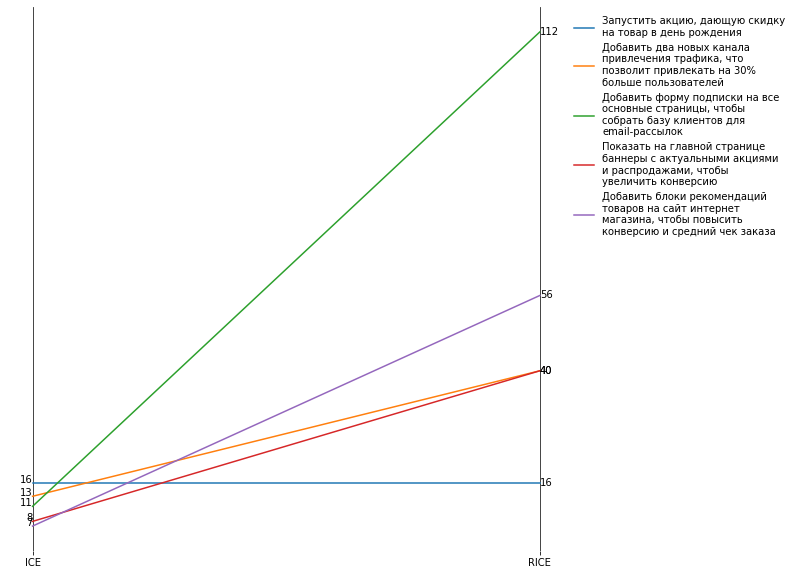

In [20]:
ICE = hypothesis.loc[:, ['Hypothesis', 'ICE']]
ICE['FW'] = 'ICE'
ICE = ICE.rename(columns = {'ICE': 'Value'})

RICE = hypothesis.loc[:, ['Hypothesis', 'RICE']]
RICE['FW'] = 'RICE'
RICE = RICE.rename(columns = {'RICE': 'Value'})

df = pd.concat([ICE, RICE])

hypothesis_names = df.sort_values(by=['FW', 'Value'], ascending=[True, False])['Hypothesis'].head(5)

fig, ax = plt.subplots(1, figsize=(10,10))

for i in hypothesis_names:
    temp = df[df['Hypothesis'] == i]
    plt.plot(temp.FW, temp.Value)
    
    plt.text(temp.FW.values[0], 
             temp.Value.values[0], 
             '{:,.0f}'.format(temp.Value.values[0]),  ha='right')
    
    plt.text(temp.FW.values[1], 
             temp.Value.values[1], 
             '{:,.0f}'.format(temp.Value.values[1]), va='center', ha='left')
    
yticks = plt.yticks()[0]
plt.yticks([])

ax.xaxis.grid(color='black', linestyle='solid', which='both', alpha=0.9)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

labels = [fill(l, 30) for l in hypothesis_names]
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.show()

**Выводы**

По фреймворку ICE можно выделить 3 гипотезы с самой высокой оценкой:
- Запустить акцию, дающую скидку на товар в день рождения;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

По фреймворку RICE можно выделить одну гипотезу, оценка которой почти в два раза превосходит остальные:

- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

Две наиболее приоритетные гипотезы по ICE, уступили другой гипотезе в фреймворке RICE. Это можно объяснить влиянием параметра Reach - охват пользователей. Акция со скидкой на день рождения охватит лишь небольшую часть пользвателей, чей день рождения попал в период проведения акции, поэтому параметр Reach низкий. Привлечение дополнительных 30 % пользователей дает соответственно 3 балла по параметру Reach, что также немного. А вот создание базы клиентов для рассылки охватит почти всех пользователей - 10 баллов Reach.

Полученные оценки позволили выделить приоритетную гипотезу для проверки - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

## Анализ A/B-теста

Проведен A/B-тест и получены результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

### Кумулятивные метрики
#### График кумулятивной выручки по группам

In [21]:
datesGroups = orders[['date', 'group']].drop_duplicates() # датафрейм с уникальными парами значений 'date' и 'group'

# данные по заказам для каждой пары 'date' и 'group'
ordersAggregated = (
    datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)

# данные по посещениям для каждой пары 'date' и 'group'
visitorsAggregated = (
    datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)

# объединим заказы и посещения по дате и группе
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


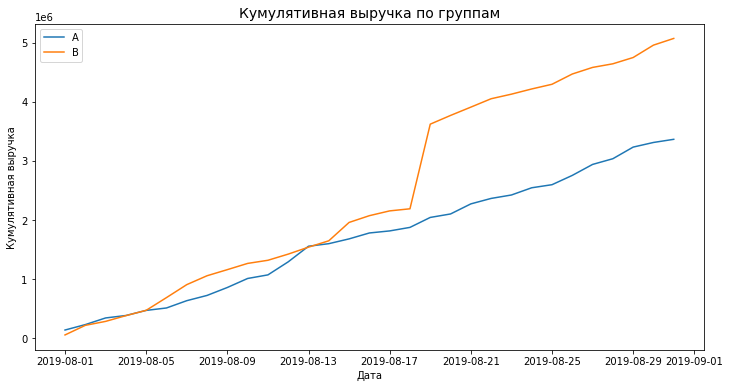

In [22]:
# разделим кумулятивные данные по группам на две переменные
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# построим график кумулятивной выручки по дням по группам 

plt.figure(figsize=(12, 6))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.legend()
plt.title('Кумулятивная выручка по группам', fontsize=14)
plt.show()

**Выводы**

До середины теста группы шли относительно ровно, однако потом у группы B случился сильный скачок. К концу теста кумулятивная выручка группы B оказалась стабильно выше группы A, что можно объяснить аномальным скачком после середины исследования.

#### График кумулятивного среднего чека по группам

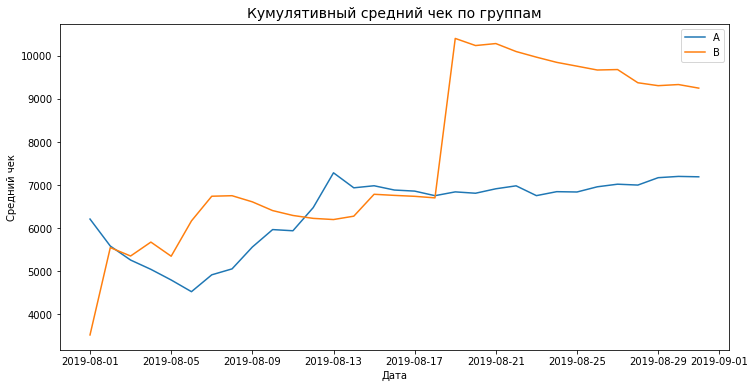

In [23]:
# построим график кумулятивного среднего чека по группам
plt.figure(figsize=(12, 6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend()
plt.title('Кумулятивный средний чек по группам', fontsize=14)
plt.show()

**Выводы**

По среднему чеку также наблюдается сильный скачок после прохождения середины исследования. К концу теста средний чек группы B оказалась стабильно выше группы A.


#### График относительного изменения кумулятивного среднего чека группы B к группе A.

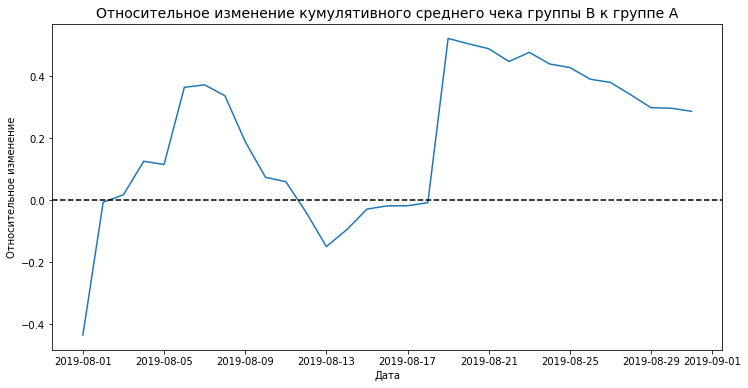

In [24]:
# объединим кумулятивные данные групп в одну таблицу
mergedCumulativeRevenue = (
    cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)

# построим график относительного изменения кумулятивного среднего чека группы B к группе A
plt.figure(figsize=(12, 6))
plt.plot(
    mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
    (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1
)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A', fontsize=14)
plt.show()

**Выводы**

График демонстрирует преобладание группы B по среднему чеку, с относительным выравниванием до нуля в середине исследования. Затем случился резкий скачок вверх и дальнейший медленный спад. Так как данные кумулятивные, преобладание группы B к концу исследования может быть вызвано аномальным скачком вверх после прохождения середины исследования.

#### График кумулятивной конверсии по группам

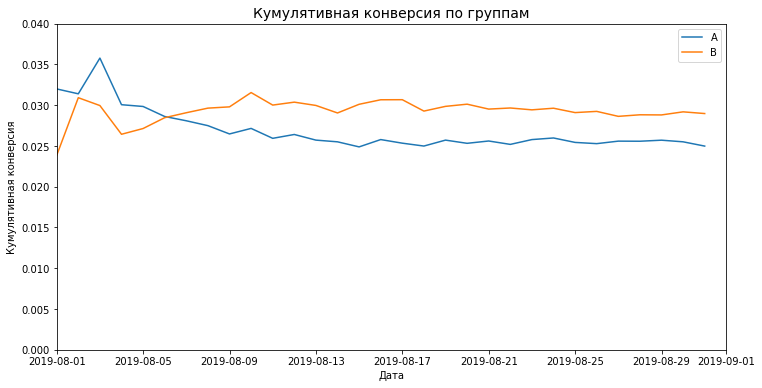

In [25]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(12, 6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.04])

plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.legend()
plt.title('Кумулятивная конверсия по группам', fontsize=14)
plt.show()

**Выводы**

В начале наблюдалась неопределенность, однако затем группа B вышла вперед с отрывом около 4%

#### График относительного изменения кумулятивной конверсии группы B к группе A.

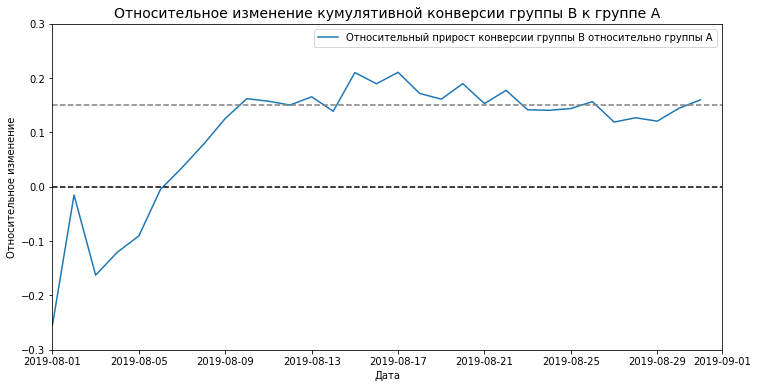

In [26]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.3, 0.3])

plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A', fontsize=14)
plt.show()

**Выводы**

К концу исследования конверсия группы B стабилизировалась со значением в среднем на 15 % выше относительно конверсии группы A.

### Анализ выбросов и всплесков

#### График количества заказов по пользователям

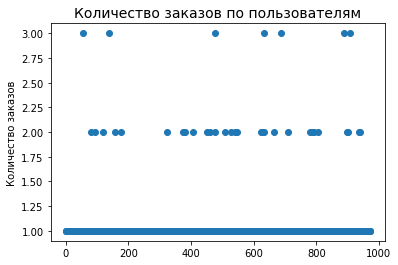

In [27]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']

x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])

plt.ylabel('Количество заказов')
plt.title('Количество заказов по пользователям', fontsize=14)
plt.show()

**Выводы**

Существует относительно небольшое количество пользователей с заказами больше 2.

#### Расчет 95-го и 99-го перцентилей количества заказов на пользователя. Выбор границы для определения аномальных пользователей

In [28]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

**Выводы**

Не более 5 % пользователей совершили более 1 заказа, и не более 1 % совершили более 2 заказов. В качестве границы выберем более 2 заказов. 

#### График стоимостей заказов

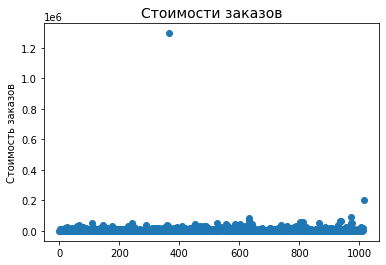

In [29]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.ylabel('Стоимость заказов')
plt.title('Стоимости заказов', fontsize=14)
plt.show()

**Выводы**

Есть небольшое количество очень дорогих заказов.

#### Расчет 95-го и 99-го перцентилей стоимостей заказов. Выбор границы для определения аномальных заказов

In [30]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

**Выводы**

Не более 5 % пользователей совершили заказы дороже 26 000, и не более 1 % - дороже 53 000. В качестве границы выберем более 60 000. 

### Расчет статистической значимости 

Подготовим данные для расчета статистической значимости

In [31]:
# посчитем количество пользователей в выбранную дату в группе A
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# посчитем количество пользователей до выбранной даты включительно в группе A
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# посчитем количество пользователей в выбранную дату в группе B
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# посчитем количество пользователей до выбранной даты включительно в группе B
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# посчитем количество заказов и выручки в выбранную дату в группе A
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# посчитем суммарное число заказов и выручки до выбранной даты включительно в группе A
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

# посчитем количество заказов и выручки в выбранную дату в группе B
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# посчитем суммарное число заказов и выручки до выбранной даты включительно в группе B
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# объединим все данные по дате
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

# посчитем число совершённых заказов в группе A
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

# посчитем число совершённых заказов в группе B
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

#### Расчет статистической значимости различий в конверсии между группами по «сырым» данным

Проверим распределение на нормальность с использованием критерия Шапиро-Уилка (st.shapiro(x)). За нулевую гипотезу примем утверждение о том, что распределение не нормально. Альтернативной гипотезой будет утверждение о том, что данные распределены нормально. Критический уровень статистической значимости установим в 5 %.

In [32]:
# создадим списки с количеством заказов для каждого из пользователей и
# нулями для пользователей, которые ничего не заказывали, для каждой группы
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# проверка критерием Шапиро-Уилка
('p-значение: ', (stats.shapiro(sampleA)[1]))

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


('p-значение: ', 0.0)

Сформулируем гипотезу. За нулевую гипотезу примем утверждение о том, что конверсия группы B равна конверсии группы A. Альтернативной гипотезой будет утверждение о том, что конверсии групп не равны. Проверку гипотез проведем с использованием критерия Манна-Уитни. Критический уровень статистической значимости установим в 5 %.

In [33]:
# проверка критерием Манна-Уитни
display('p-значение: ', "{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative="two-sided")[1]))

# относительный прирост конверсии
display('относительный прирост конверсии: ', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

'p-значение: '

'0.01102'

'относительный прирост конверсии: '

'0.160'

**Выводы**

P-value меньше 0.05, нулевую гипотезу отвергаем. По сырым данным между группами есть статистически значимые различия. Конверсия группы B выше на 16 % относительно группы A.

#### Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезу. За нулевую гипотезу примем утверждение о том, что средний чек заказа группы B равен среднему чеку заказа  группы A. Альтернативной гипотезой будет утверждение о том, что средние чеки групп не равны. Проверку гипотез проведем с использованием критерия Манна-Уитни. Критический уровень статистической значимости установим в 5 %.

In [34]:
# проверка критерием Манна-Уитни
display('p-значение: ', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative="two-sided")[1]))

# относительный прирост среднего чека группы B
display('относительный прирост среднего чека: ', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

'p-значение: '

'0.829'

'относительный прирост среднего чека: '

'0.287'

**Выводы**

P-value больше 0.05, статистически значимых отличий нет. При этом средний чек группы B выше на 28.7 % относительно группы A.

#### Расчет статистической значимости различий в конверсии между группами по «очищенным» данным

Сформулируем гипотезу. За нулевую гипотезу примем утверждение о том, что конверсия группы B равна конверсии группы A. Альтернативной гипотезой будет утверждение о том, что конверсии групп не равны. Проверку гипотез проведем с использованием критерия Манна-Уитни. Критический уровень статистической значимости установим в 5 %.

In [35]:
# выделим пользователей с большим количеством зказов
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)

# выделим пользователей с дорогими зказами
usersWithExpensiveOrders = orders[orders['revenue'] > 60000]['visitorId']

# объединим пользователей с аномальными заказами, удалим дубликаты
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
len(abnormalUsers)

15

Всего получилось 15 аномальных пользователей.

In [36]:
# создадим отфильтрованный набор данных по заказам для каждой группы  
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


In [37]:
# проверка критерием Манна-Уитни
display('p-значение: ', '{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative="two-sided")[1]))

# относительный прирост конверсии группы B
display('относительный прирост конверсии: ', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

'p-значение: '

'0.00641'

'относительный прирост конверсии: '

'0.191'

P-value меньше 0.05, нулевую гипотезу отвергаем. По отфильтрованным данным между группами также есть статистически значимые различия. Конверсия группы B выше на 19.1 % относительно группы A, что выше на 3 % чем по сырым данным.

#### Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем гипотезу. За нулевую гипотезу примем утверждение о том, что средний чек заказа группы B равен среднему чеку заказа  группы A. Альтернативной гипотезой будет утверждение о том, что средние чеки групп не равны. Проверку гипотез проведем с использованием критерия Манна-Уитни. Критический уровень статистической значимости установим в 5 %.

In [38]:
# проверка критерием Манна-Уитни
display('p-значение: ',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'], alternative="two-sided"
        )[1]
    )
)

# относительное различие среднего чека группы B
display('относительное различие среднего чека: ',
        "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1)
    )

'p-значение: '

'0.827'

'относительное различие среднего чека: '

'-0.017'

**Выводы**

P-value больше 0.05, статистически значимых отличий нет. При этом средний чек группы B меньше на 1 % относительно группы A. Прирост среденего чека в 28 % по сырым данным объясняется наличием аномальных заказов.

## Общий вывод

По результатам исследования можно сделать следующие выводы:
- Приоритизация гипотез по фреймворкам ICE и RICE позволила выделить приоритетную гипотезу для проверки - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".
- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
- По сырым данным нет статистически значимого различия по среднему чеку между группами, однако средний чек группы B выше на 29 %. После удаления аномалий статистически значимого различия нет, относительное различие среднего чека -1 %.
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.
- График различия среднего чека колеблется, было выявлено, что колебания связаны с аномалиями
- Обнаружена серьезная ошибка в тесте - группы имеют разное количество пользователей. Группа B больше по относительному количеству пользователей на 15 %. Также имеются пользователи, попавшие в обе группы сразу. 

По результатам A/B-теста можно принять решение об остановке теста и зафиксировать отсутствие различий между группами. Конверсия группы B показала статистически значимое различие в 19 %, однако это различие может быть связано с превышением размера группы на 15 %. Средний чек не показал статистически значимого различия.
